# analisis utility

In [1]:
# Juan: configuracion del jugador y la api

RIOT_ID = "LgndJuanillo#LGNDJ"

PLATFORM_REGION = "la1"

REGIONAL_ROUTE = "americas"

RIOT_API_KEY = ""

# Juan: colas objetivo ejemplo [420] soloq [440] flex

TARGET_QUEUES = [420]

# Juan: rol objetivo utility

ROLE_TARGET = "UTILITY"

# Juan: partidas objetivo del rol luego del filtro

ROLE_TARGET_COUNT = 100

# Juan: maximo de ids a mirar hacia atras

MAX_LOOKBACK_IDS = 3000

# Juan: pausas para evitar limite

REQUEST_PAUSE_SEC = 1.3

COOLDOWN_EVERY = 25

COOLDOWN_SEC = 8


In [2]:
# Juan: pegar api key de forma segura y testear

from getpass import getpass

def sanitize_token(tok: str) -> str:

    return (tok or "").strip().strip('"').strip("'").strip()

if not RIOT_API_KEY or len(RIOT_API_KEY) < 30 or "RGAPI-" not in RIOT_API_KEY:

    RIOT_API_KEY = sanitize_token(getpass("pega tu riot api key "))

import requests

url = f"https://{PLATFORM_REGION}.api.riotgames.com/lol/status/v4/platform-data"

resp = requests.get(url, headers={"X-Riot-Token": RIOT_API_KEY}, timeout=30)

print("status plataforma", resp.status_code)

if resp.status_code == 401:

    raise RuntimeError("api key invalida o expirada vuelve a pegar la api key en esta celda")

if resp.status_code != 200:

    print("advertencia status diferente a 200 pero no es 401 puede ser mantenimiento")


status plataforma 200


In [3]:
# Juan: librerias

import requests

import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

import time

from datetime import datetime

try:

    from google.colab import data_table

    data_table.DataTable.max_columns = 240

except Exception:

    pass

pd.set_option("display.max_columns", None)

pd.set_option("display.width", 260)


In [4]:
# Juan: request

def riot_get(url, max_retries=8):

    for attempt in range(1, max_retries + 1):

        try:

            headers = {"X-Riot-Token": RIOT_API_KEY} if RIOT_API_KEY else {}

            resp = requests.get(url, headers=headers, timeout=30)

        except Exception as e:

            wait = min(12, REQUEST_PAUSE_SEC * (1.6 ** attempt))

            print("error de red intento", attempt, "esperando", round(wait,2), "s")

            time.sleep(wait)

            continue

        if resp.status_code == 200:

            return resp.json()

        if resp.status_code == 401:

            raise RuntimeError("api key invalida o expirada pega una api key nueva en la celda de seguridad y vuelve a ejecutar")

        if resp.status_code in (429, 503, 504):

            ra = resp.headers.get("Retry-After", None)

            if ra is not None:

                try:

                    wait = max(REQUEST_PAUSE_SEC, float(ra))

                except:

                    wait = REQUEST_PAUSE_SEC * (1.6 ** attempt)

            else:

                wait = REQUEST_PAUSE_SEC * (1.6 ** attempt)

            print("rate limit o ocupado", resp.status_code, "esperando", round(wait,2), "s")

            time.sleep(wait)

            continue

        print("error http", resp.status_code, "url", url)

        raise RuntimeError(f"error http {resp.status_code} en {url}")

    raise RuntimeError("agotados reintentos en " + url)

# Juan: utils

def split_riot_id(riot_id: str):

    s = riot_id.replace(" ", "")

    if "#" in s:

        name, tag = s.split("#", 1)

        return name, tag

    return s, "NA1"

def safe_int(x):

    try:

        return int(x)

    except Exception:

        return 0

QUEUE_MAP = {420: "ranked_solo", 440: "ranked_flex", 400: "normal_draft", 430: "normal_blind", 450: "aram", 1700: "arena"}

def derive_position(participant: dict, queue_id: int) -> str:

    pos = (participant.get("teamPosition") or "").upper()

    lane = (participant.get("lane") or "").upper()

    if queue_id == 450:

        return "ARAM"

    if queue_id == 1700:

        return "ARENA"

    valid = {"TOP","JUNGLE","MIDDLE","BOTTOM","UTILITY"}

    if pos in valid:

        return pos

    if lane in valid:

        return lane

    if lane == "NONE":

        return "FILL"

    return "UNKNOWN"

# Juan: endpoints

def get_account_by_riot_id(game_name, tag_line, regional):

    url = f"https://{regional}.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{game_name}/{tag_line}"

    return riot_get(url)

def get_match_ids_by_puuid_paginated(puuid, regional, start, count):

    url = f"https://{regional}.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?start={start}&count={count}"

    return riot_get(url)

def get_match_by_id(match_id, regional):

    url = f"https://{regional}.api.riotgames.com/lol/match/v5/matches/{match_id}"

    return riot_get(url)

# Juan: fetch hasta lograr 100 partidas utility

def fetch_until_role_count(riot_id: str, regional: str, target_queues: list, role_target: str, role_count: int, max_ids: int):

    name, tag = split_riot_id(riot_id)

    acct = get_account_by_riot_id(name, tag, regional)

    puuid = acct.get("puuid", "")

    if not puuid:

        raise RuntimeError("no se obtuvo puuid revisar riot id")

    collected = []

    start = 0

    calls = 0

    while len(collected) < role_count and start < max_ids:

        ids = get_match_ids_by_puuid_paginated(puuid, regional, start, min(100, max_ids - start))

        calls += 1

        if calls % COOLDOWN_EVERY == 0:

            print("cooldown", COOLDOWN_SEC, "s")

            time.sleep(COOLDOWN_SEC)

        if not ids:

            break

        print("pagina con", len(ids), "ids desde", start, "utility acumuladas", len(collected))

        for mid in ids:

            m = get_match_by_id(mid, regional)

            calls += 1

            if calls % COOLDOWN_EVERY == 0:

                print("cooldown", COOLDOWN_SEC, "s")

                time.sleep(COOLDOWN_SEC)

            info = m.get("info", {})

            qid = safe_int(info.get("queueId", 0))

            if target_queues and qid not in target_queues:

                time.sleep(REQUEST_PAUSE_SEC)

                continue

            parts = info.get("participants", [])

            player = None

            for z in parts:

                if z.get("puuid") == puuid:

                    player = z

                    break

            if not player:

                time.sleep(REQUEST_PAUSE_SEC)

                continue

            pos = derive_position(player, qid)

            if pos != role_target:

                time.sleep(REQUEST_PAUSE_SEC)

                continue

            collected.append(m)

            if len(collected) >= role_count:

                break

            time.sleep(REQUEST_PAUSE_SEC)

        start += len(ids)

    return collected, puuid


In [5]:
# Juan: descargar partidas utility hasta 100

matches, puuid = fetch_until_role_count(RIOT_ID, REGIONAL_ROUTE, TARGET_QUEUES, ROLE_TARGET, ROLE_TARGET_COUNT, MAX_LOOKBACK_IDS)

print("partidas utility descargadas", len(matches))


pagina con 100 ids desde 0 utility acumuladas 0
cooldown 8 s
cooldown 8 s
cooldown 8 s
cooldown 8 s
pagina con 100 ids desde 100 utility acumuladas 27
cooldown 8 s
cooldown 8 s
cooldown 8 s
cooldown 8 s
pagina con 100 ids desde 200 utility acumuladas 46
cooldown 8 s
cooldown 8 s
cooldown 8 s
cooldown 8 s
pagina con 100 ids desde 300 utility acumuladas 66
cooldown 8 s
cooldown 8 s
cooldown 8 s
cooldown 8 s
pagina con 100 ids desde 400 utility acumuladas 82
cooldown 8 s
cooldown 8 s
partidas utility descargadas 100


In [6]:
# Juan: construir dataframe utility

rows = []

for m in matches:

    info = m.get("info", {})

    when_ts = info.get("gameStartTimestamp", None)

    when = pd.to_datetime(when_ts, unit="ms") if when_ts else pd.NaT

    queue_id = safe_int(info.get("queueId", 0))

    queue_name = QUEUE_MAP.get(queue_id, str(queue_id))

    game_version = info.get("gameVersion", "")

    parts = info.get("participants", [])

    teams = info.get("teams", [])

    p = None

    for z in parts:

        if z.get("puuid") == puuid:

            p = z

            break

    if not p:

        continue

    pos = (p.get("teamPosition") or "").upper()

    if pos != "UTILITY":

        pos = "UTILITY"

    k = safe_int(p.get("kills", 0))

    d = safe_int(p.get("deaths", 0))

    a = safe_int(p.get("assists", 0))

    kda = (k + a) / max(1, d)

    dur = safe_int(p.get("timePlayed", info.get("gameDuration", 0)))

    mins = max(1, dur) / 60.0

    dmg = safe_int(p.get("totalDamageDealtToChampions", 0))

    gold = safe_int(p.get("goldEarned", 0))

    cs = safe_int(p.get("totalMinionsKilled", 0)) + safe_int(p.get("neutralMinionsKilled", 0))

    vis = safe_int(p.get("visionScore", 0))

    w_placed = safe_int(p.get("wardsPlaced", 0))

    w_killed = safe_int(p.get("wardsKilled", 0))

    ctrl_wards = safe_int(p.get("visionWardsBoughtInGame", 0))

    dmg_taken = safe_int(p.get("totalDamageTaken", 0))

    dmg_self_mit = safe_int(p.get("damageSelfMitigated", 0))

    team_id = p.get("teamId", None)

    tk = None

    team_obj = {"baron":0, "dragon":0, "riftHerald":0, "tower":0}

    try:

        for t in teams:

            if safe_int(t.get("teamId")) == safe_int(team_id):

                tk = safe_int(t.get("objectives", {}).get("champion", {}).get("kills", 0))

                team_obj["baron"] = safe_int(t.get("objectives", {}).get("baron", {}).get("kills", 0))

                team_obj["dragon"] = safe_int(t.get("objectives", {}).get("dragon", {}).get("kills", 0))

                team_obj["riftHerald"] = safe_int(t.get("objectives", {}).get("riftHerald", {}).get("kills", 0))

                team_obj["tower"] = safe_int(t.get("objectives", {}).get("tower", {}).get("kills", 0))

                break

    except Exception:

        tk = None

    kp = ((k + a) / tk) if tk and tk > 0 else None

    adc_champ = None

    for z in parts:

        if safe_int(z.get("teamId", -1)) == safe_int(team_id) and (z.get("teamPosition") or "").upper() == "BOTTOM":

            adc_champ = z.get("championName", "NA")

            break

    rows.append({

        "match_id": m.get("metadata", {}).get("matchId", "NA"),

        "when": when,

        "patch": ".".join(game_version.split(".")[:2]) if game_version else "NA",

        "queue_id": queue_id,

        "queue_name": queue_name,

        "champion": p.get("championName", "NA"),

        "position": "UTILITY",

        "adc_mate": adc_champ,

        "kills": k,

        "deaths": d,

        "assists": a,

        "kda": round(kda, 2),

        "win": bool(p.get("win", False)),

        "damage_to_champs": dmg,

        "gold": gold,

        "cs": cs,

        "vision": vis,

        "wards_placed": w_placed,

        "wards_killed": w_killed,

        "ctrl_wards": ctrl_wards,

        "mins": round(mins, 2),

        "kpm": round(k / mins, 2),

        "dpm": round(dmg / mins, 2),

        "gpm": round(gold / mins, 2),

        "csm": round(cs / mins, 2),

        "vpm": round(vis / mins, 2),

        "wpm": round(w_placed / mins, 3),

        "wkpm": round(w_killed / mins, 3),

        "d_taken_pm": round(dmg_taken / mins, 1),

        "d_self_mit_pm": round(dmg_self_mit / mins, 1),

        "kp": round(kp, 2) if kp is not None else None,

        "hour": when.hour if pd.notna(when) else None,

        "weekday": when.weekday() if pd.notna(when) else None,

        "team_barons": team_obj["baron"],

        "team_dragons": team_obj["dragon"],

        "team_heralds": team_obj["riftHerald"],

        "team_towers": team_obj["tower"],

        "duration_mins": round(mins, 2),

    })

df = pd.DataFrame(rows).sort_values(by="when").reset_index(drop=True)

if len(df) > ROLE_TARGET_COUNT:

    df = df.tail(ROLE_TARGET_COUNT).reset_index(drop=True)

print("filas utility en dataframe", len(df))

df.head()


filas utility en dataframe 100


,match_id,when,patch,queue_id,queue_name,champion,position,adc_mate,kills,deaths,assists,kda,win,damage_to_champs,gold,cs,vision,wards_placed,wards_killed,ctrl_wards,mins,kpm,dpm,gpm,csm,vpm,wpm,wkpm,d_taken_pm,d_self_mit_pm,kp,hour,weekday,team_barons,team_dragons,team_heralds,team_towers,duration_mins
0,LA1_1561715467,2024-10-04 00:38:50.173,14.19,420,ranked_solo,Bard,UTILITY,Jhin,0,3,2,0.67,False,2884,3355,12,19,9,2,2,15.45,0.00,186.67,217.15,0.78,1.23,0.583,0.129,428.1,296.6,0.29,0,4,0,0,0,0,15.45
1,LA1_1562166240,2024-10-05 19:16:38.968,14.19,420,ranked_solo,Leona,UTILITY,MissFortune,0,3,15,5.00,True,9192,8315,29,72,29,10,9,28.12,0.00,326.92,295.73,1.03,2.56,1.031,0.356,578.4,671.8,0.56,19,5,1,4,1,9,28.12
2,LA1_1562173442,2024-10-05 19:55:07.087,14.19,420,ranked_solo,Senna,UTILITY,Caitlyn,0,0,4,4.00,True,2537,3795,25,19,10,1,5,15.38,0.00,164.92,246.70,1.63,1.24,0.650,0.065,299.3,112.3,0.31,19,5,0,2,0,0,15.38
3,LA1_1562180103,2024-10-05 20:18:55.695,14.19,420,ranked_solo,Senna,UTILITY,Aphelios,2,5,23,5.00,False,11307,12468,67,106,39,11,9,39.78,0.05,284.21,313.40,1.68,2.66,0.980,0.276,583.3,342.5,0.51,20,5,0,1,0,11,39.78
4,LA1_1562841031,2024-10-08 02:38:12.608,14.19,420,ranked_solo,Senna,UTILITY,Ziggs,0,2,6,3.00,True,4922,4540,23,50,16,11,7,16.57,0.00,297.10,274.04,1.39,3.02,0.966,0.664,554.2,226.7,0.40,2,1,0,0,1,1,16.57


In [7]:
# Juan: features y agregados

df["result"] = df["win"].map({True: "win", False: "loss"})

for col, win in [("kda","kda_ma10"), ("dpm","dpm_ma10"), ("gpm","gpm_ma10"), ("csm","csm_ma10"), ("vpm","vpm_ma10")]:

    df[win] = df[col].rolling(window=10, min_periods=1).mean().round(2)

df["kp_ma10"] = df["kp"].rolling(window=10, min_periods=1).mean().round(2)

df["wpm_ma10"] = df["wpm"].rolling(window=10, min_periods=1).mean().round(3)

df["vision_eff"] = (df["vpm"] / df["wpm"].replace(0, np.nan)).replace(np.nan, 0).round(3)

wins_numeric = df["win"].astype(int)

df["rolling_winrate10"] = (wins_numeric.rolling(10, min_periods=1).mean() * 100).round(1)

summary = {

    "total_utility": len(df),

    "wins": int(df["win"].sum()),

    "losses": int(len(df) - df["win"].sum()),

    "winrate": round(100.0 * df["win"].mean(), 1) if len(df) else None,

    "kda_avg": round(df["kda"].mean(), 2) if len(df) else None,

    "dpm_avg": round(df["dpm"].mean(), 1) if len(df) else None,

    "gpm_avg": round(df["gpm"].mean(), 1) if len(df) else None,

    "csm_avg": round(df["csm"].mean(), 2) if len(df) else None,

    "vpm_avg": round(df["vpm"].mean(), 2) if len(df) else None,

    "wpm_avg": round(df["wpm"].mean(), 3) if len(df) else None,

    "wkpm_avg": round(df["wkpm"].mean(), 3) if len(df) else None,

    "kp_avg": round(df["kp"].dropna().mean(), 2) if df["kp"].notna().any() else None,

    "vision_eff_avg": round(df["vision_eff"].mean(), 3) if len(df) else None,

}

print(summary)

agg_champ = df.groupby("champion", as_index=False).agg(

    games=("match_id", "count"),

    wins=("win", "sum"),

    winrate=("win", lambda s: round(100.0 * s.mean(), 1)),

    kda_avg=("kda", "mean"),

    dpm_avg=("dpm", "mean"),

    gpm_avg=("gpm", "mean"),

    csm_avg=("csm", "mean"),

    vpm_avg=("vpm", "mean"),

    wpm_avg=("wpm", "mean"),

    wkpm_avg=("wkpm", "mean"),

    kp_avg=("kp", "mean"),

    vision_eff_avg=("vision_eff", "mean"),

).round(2).sort_values(by=["games","winrate"], ascending=[False, False])

agg_adc = df.groupby("adc_mate", as_index=False).agg(

    games=("match_id", "count"),

    wins=("win", "sum"),

    winrate=("win", lambda s: round(100.0 * s.mean(), 1)),

    kda_avg=("kda", "mean"),

    kp_avg=("kp", "mean"),

).round(2).sort_values(by=["games","winrate"], ascending=[False, False])

agg_patch = df.groupby("patch", as_index=False).agg(

    games=("match_id", "count"),

    winrate=("win", lambda s: round(100.0 * s.mean() * 100, 1))

).sort_values(by="patch")


{'total_utility': 100, 'wins': 45, 'losses': 55, 'winrate': np.float64(45.0), 'kda_avg': np.float64(4.64), 'dpm_avg': np.float64(368.2), 'gpm_avg': np.float64(286.6), 'csm_avg': np.float64(1.35), 'vpm_avg': np.float64(2.13), 'wpm_avg': np.float64(0.9), 'wkpm_avg': np.float64(0.215), 'kp_avg': np.float64(0.51), 'vision_eff_avg': np.float64(2.289)}


In [8]:
# Juan: vista curada

cols_core = ["when","patch","queue_name","champion","adc_mate","kills","deaths","assists","kda","win","gpm","dpm","csm","vpm","wpm","wkpm","kp","vision_eff","duration_mins"]

df_view = df.loc[:, [c for c in cols_core if c in df.columns]]

df_view.head(25)


,when,patch,queue_name,champion,adc_mate,kills,deaths,assists,kda,win,gpm,dpm,csm,vpm,wpm,wkpm,kp,vision_eff,duration_mins
0,2024-10-04 00:38:50.173,14.19,ranked_solo,Bard,Jhin,0,3,2,0.67,False,217.15,186.67,0.78,1.23,0.583,0.129,0.29,2.110,15.45
1,2024-10-05 19:16:38.968,14.19,ranked_solo,Leona,MissFortune,0,3,15,5.00,True,295.73,326.92,1.03,2.56,1.031,0.356,0.56,2.483,28.12
2,2024-10-05 19:55:07.087,14.19,ranked_solo,Senna,Caitlyn,0,0,4,4.00,True,246.70,164.92,1.63,1.24,0.650,0.065,0.31,1.908,15.38
3,2024-10-05 20:18:55.695,14.19,ranked_solo,Senna,Aphelios,2,5,23,5.00,False,313.40,284.21,1.68,2.66,0.980,0.276,0.51,2.714,39.78
4,2024-10-08 02:38:12.608,14.19,ranked_solo,Senna,Ziggs,0,2,6,3.00,True,274.04,297.10,1.39,3.02,0.966,0.664,0.40,3.126,16.57
5,2024-10-08 03:02:07.130,14.19,ranked_solo,Senna,Ziggs,3,5,13,3.20,False,264.83,363.24,0.91,1.94,0.799,0.297,0.53,2.428,43.82
6,2024-10-08 21:29:38.497,14.19,ranked_solo,Senna,Ashe,1,2,18,9.50,True,327.79,326.01,0.91,2.48,0.976,0.314,0.70,2.541,28.68
7,2024-10-10 03:32:51.208,14.20,ranked_solo,Senna,Nilah,2,4,24,6.50,True,311.04,529.72,1.02,2.35,0.987,0.261,0.62,2.381,34.43
8,2024-10-10 04:17:20.694,14.20,ranked_solo,Karma,Jinx,0,5,6,1.20,False,226.26,289.23,1.22,2.55,1.074,0.225,0.27,2.374,40.03
9,2024-10-10 17:50:01.306,14.20,ranked_solo,Nami,Jhin,1,9,15,1.78,False,254.42,457.56,0.90,2.45,0.954,0.300,0.62,2.568,36.68


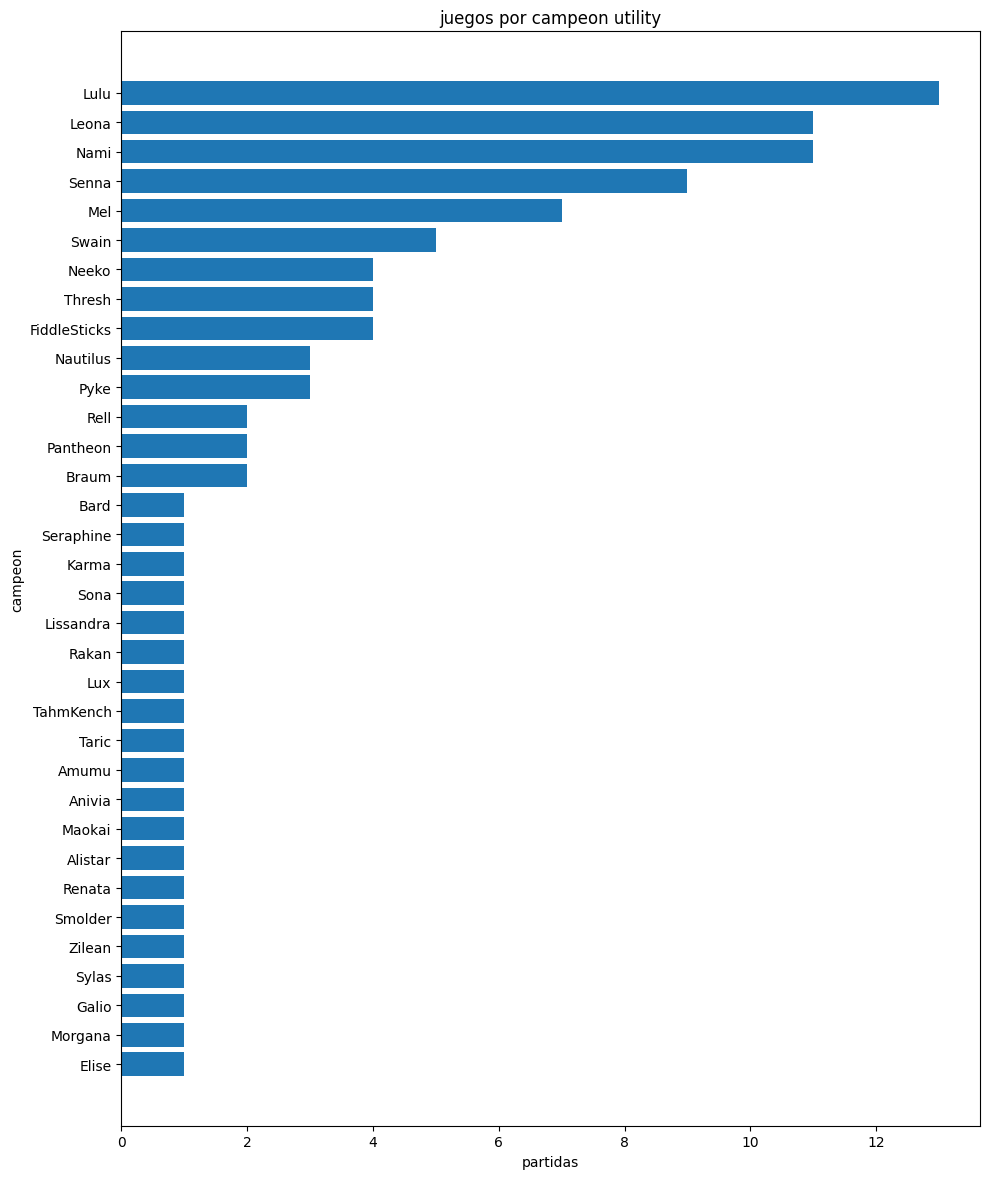

In [9]:
# Juan: juegos por campeon utility

counts = df["champion"].value_counts()

plt.figure(figsize=(10, max(4, 0.35 * len(counts))))

plt.barh(counts.index, counts.values)

plt.title("juegos por campeon utility")

plt.xlabel("partidas")

plt.ylabel("campeon")

plt.gca().invert_yaxis()

plt.tight_layout()

plt.show()


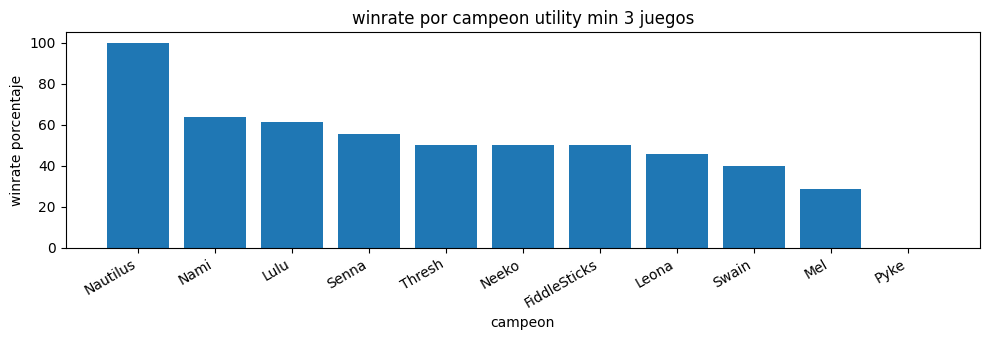

In [10]:
# Juan: winrate por campeon utility min 3 juegos

a2 = agg_champ[agg_champ["games"] >= 3].sort_values(by="winrate", ascending=False)

plt.figure(figsize=(10, max(3.5, 0.3 * len(a2))))

plt.bar(a2["champion"], a2["winrate"])

plt.title("winrate por campeon utility min 3 juegos")

plt.xlabel("campeon")

plt.ylabel("winrate porcentaje")

plt.xticks(rotation=30, ha="right")

plt.tight_layout()

plt.show()


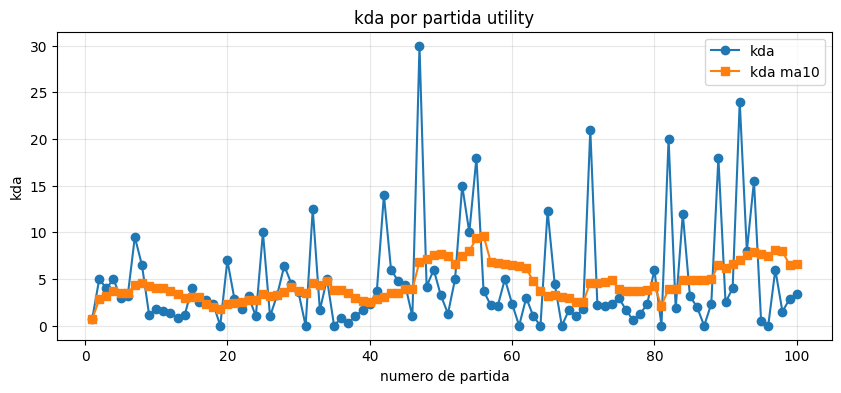

In [11]:
# Juan: kda y ma10 utility

plt.figure(figsize=(10,4))

plt.plot(range(1, len(df)+1), df["kda"], marker="o", label="kda")

plt.plot(range(1, len(df)+1), df["kda_ma10"], marker="s", label="kda ma10")

plt.title("kda por partida utility")

plt.xlabel("numero de partida")

plt.ylabel("kda")

plt.grid(True, alpha=0.3)

plt.legend()

plt.show()


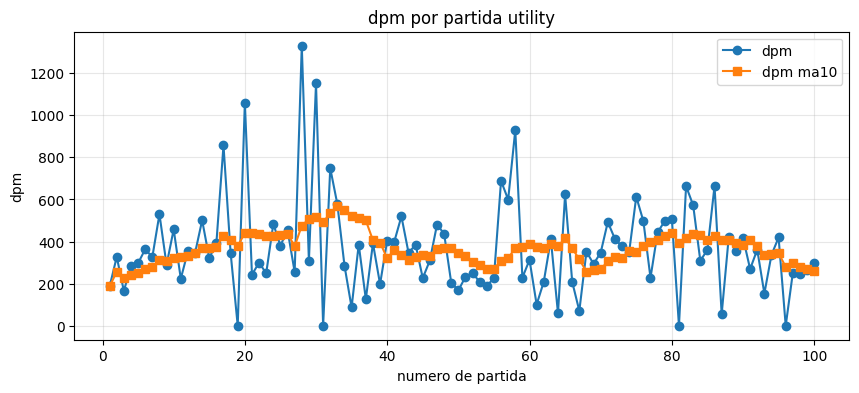

In [12]:
# Juan: dpm y ma10 utility

plt.figure(figsize=(10,4))

plt.plot(range(1, len(df)+1), df["dpm"], marker="o", label="dpm")

plt.plot(range(1, len(df)+1), df["dpm_ma10"], marker="s", label="dpm ma10")

plt.title("dpm por partida utility")

plt.xlabel("numero de partida")

plt.ylabel("dpm")

plt.grid(True, alpha=0.3)

plt.legend()

plt.show()


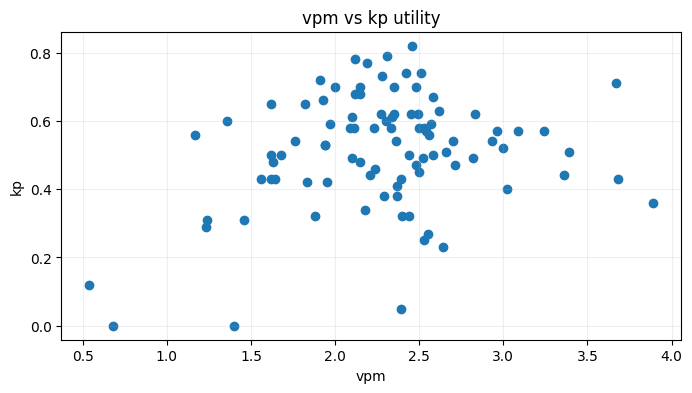

In [13]:
# Juan: vpm y kp utility

plt.figure(figsize=(8,4))

plt.scatter(df["vpm"], df["kp"])

plt.title("vpm vs kp utility")

plt.xlabel("vpm")

plt.ylabel("kp")

plt.grid(True, alpha=0.2)

plt.show()


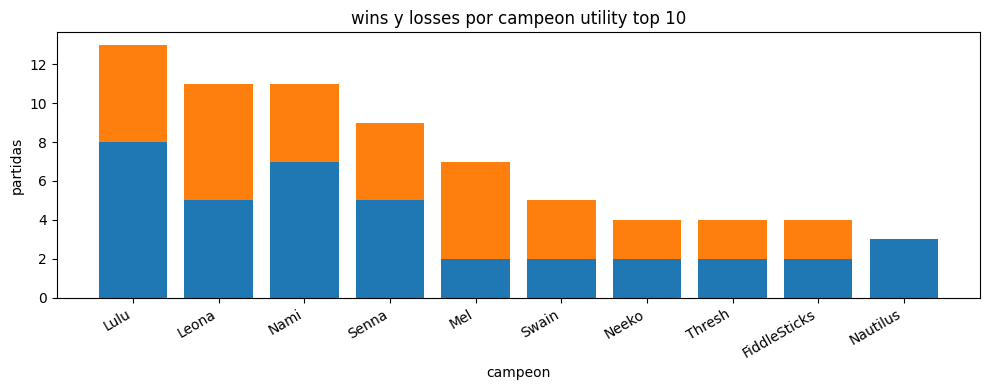

In [14]:
# Juan: wins y losses por campeon utility top 10

top = df["champion"].value_counts().head(10).index.tolist()

t = df[df["champion"].isin(top)].groupby(["champion","win"]).size().unstack(fill_value=0).loc[top]

wins = t.get(True, 0).values

losses = t.get(False, 0).values

x = np.arange(len(top))

plt.figure(figsize=(10,4))

plt.bar(x, wins)

plt.bar(x, losses, bottom=wins)

plt.title("wins y losses por campeon utility top 10")

plt.xlabel("campeon")

plt.ylabel("partidas")

plt.xticks(x, top, rotation=30, ha="right")

plt.tight_layout()

plt.show()


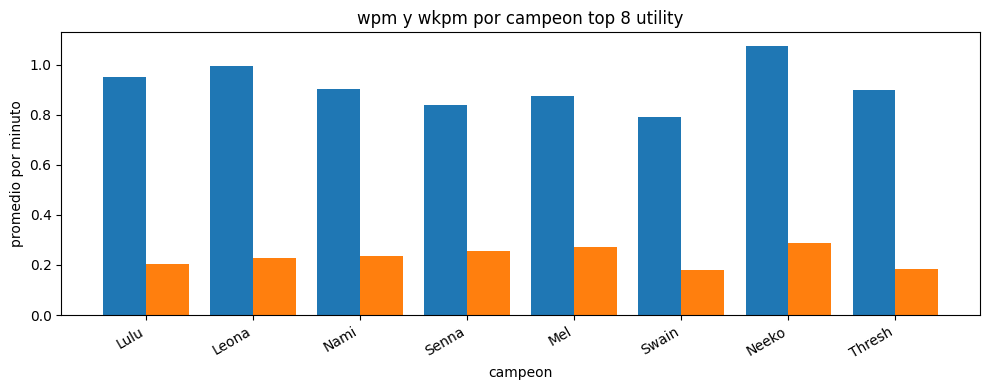

In [15]:
# Juan: wpm y wkpm por campeon top 8

top8 = df["champion"].value_counts().head(8).index.tolist()

sub = df[df["champion"].isin(top8)]

wp = sub.groupby("champion")["wpm"].mean().loc[top8]

wk = sub.groupby("champion")["wkpm"].mean().loc[top8]

x = np.arange(len(top8))

plt.figure(figsize=(10,4))

plt.bar(x - 0.2, wp.values, width=0.4)

plt.bar(x + 0.2, wk.values, width=0.4)

plt.title("wpm y wkpm por campeon top 8 utility")

plt.xlabel("campeon")

plt.ylabel("promedio por minuto")

plt.xticks(x, top8, rotation=30, ha="right")

plt.tight_layout()

plt.show()


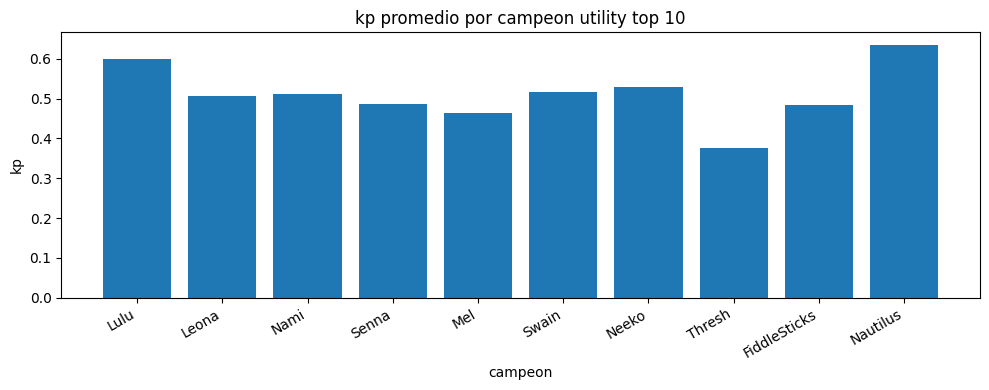

In [16]:
# Juan: kp por campeon top 10

top10 = df["champion"].value_counts().head(10).index.tolist()

kpv = df.groupby("champion")["kp"].mean().loc[top10]

plt.figure(figsize=(10,4))

plt.bar(top10, kpv.values)

plt.title("kp promedio por campeon utility top 10")

plt.xlabel("campeon")

plt.ylabel("kp")

plt.xticks(rotation=30, ha="right")

plt.tight_layout()

plt.show()


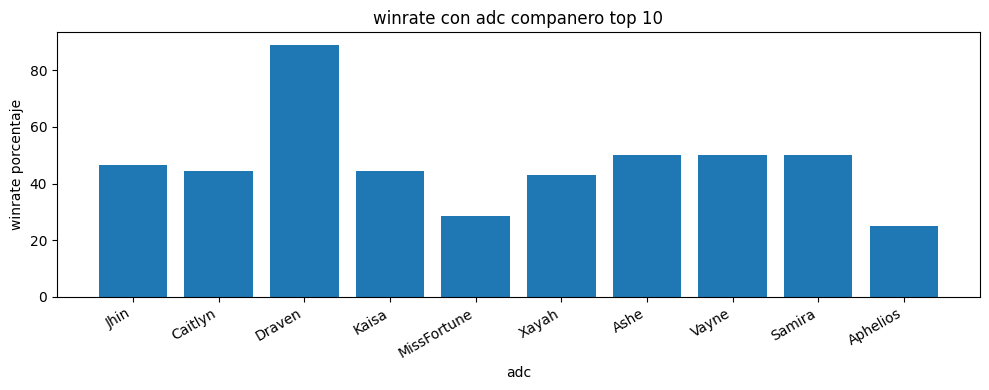

In [17]:
# Juan: sinergia con adc winrate por adc top 10

top_adc = df["adc_mate"].value_counts().head(10).index.tolist()

adct = df[df["adc_mate"].isin(top_adc)].groupby(["adc_mate","win"]).size().unstack(fill_value=0).loc[top_adc]

wr = adct.get(True, 0) / (adct.get(True, 0) + adct.get(False, 0) + 1e-9) * 100

plt.figure(figsize=(10,4))

plt.bar(top_adc, wr.values)

plt.title("winrate con adc companero top 10")

plt.xlabel("adc")

plt.ylabel("winrate porcentaje")

plt.xticks(rotation=30, ha="right")

plt.tight_layout()

plt.show()


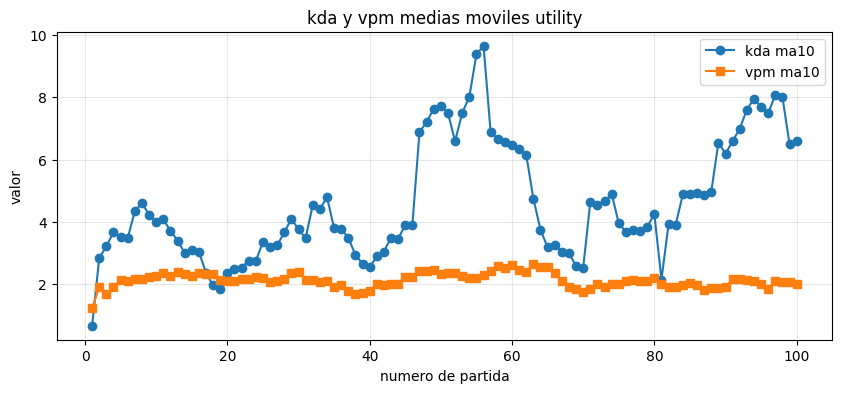

In [18]:
# Juan: kda y vpm medias moviles utility

plt.figure(figsize=(10,4))

plt.plot(range(1, len(df)+1), df["kda_ma10"], marker="o", label="kda ma10")

plt.plot(range(1, len(df)+1), df["vpm_ma10"], marker="s", label="vpm ma10")

plt.title("kda y vpm medias moviles utility")

plt.xlabel("numero de partida")

plt.ylabel("valor")

plt.grid(True, alpha=0.3)

plt.legend()

plt.show()


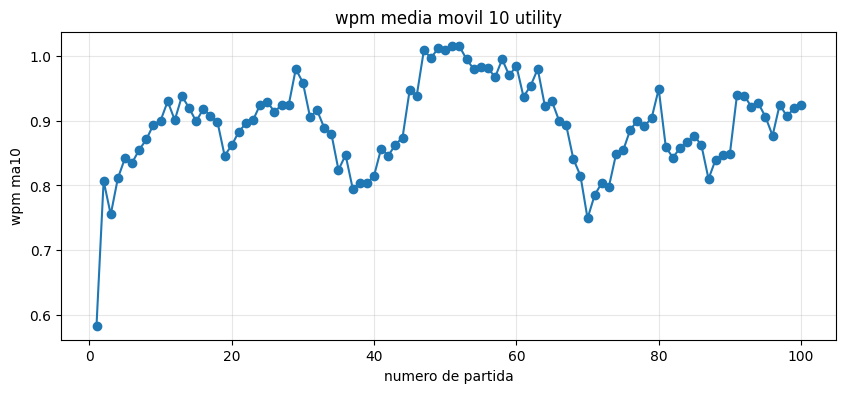

In [19]:
# Juan: wpm media movil 10 utility

plt.figure(figsize=(10,4))

plt.plot(range(1, len(df)+1), df["wpm_ma10"], marker="o")

plt.title("wpm media movil 10 utility")

plt.xlabel("numero de partida")

plt.ylabel("wpm ma10")

plt.grid(True, alpha=0.3)

plt.show()


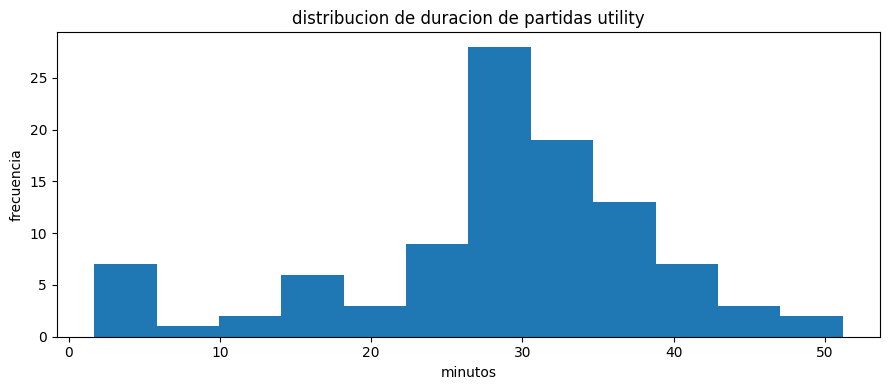

In [20]:
# Juan: distribucion duracion de partidas

plt.figure(figsize=(9,4))

plt.hist(df["duration_mins"], bins=12)

plt.title("distribucion de duracion de partidas utility")

plt.xlabel("minutos")

plt.ylabel("frecuencia")

plt.tight_layout()

plt.show()


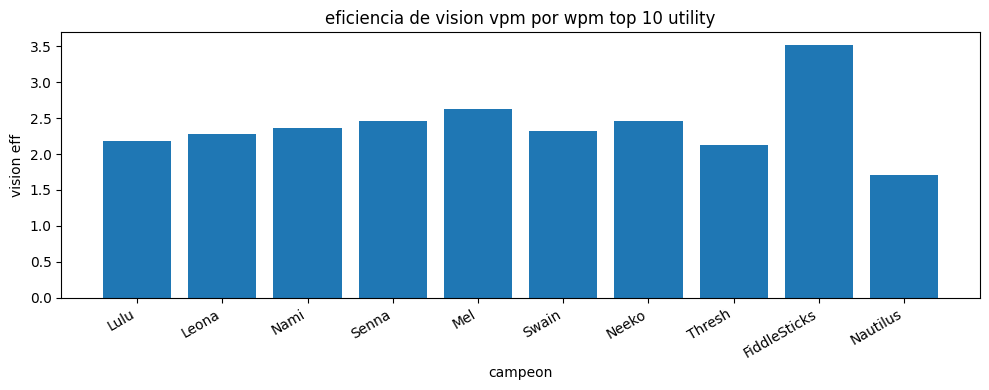

In [21]:
# Juan: eficiencia de vision por campeon top 10

top10 = df["champion"].value_counts().head(10).index.tolist()

ve = agg_champ.set_index("champion").loc[top10]["vision_eff_avg"]

plt.figure(figsize=(10,4))

plt.bar(top10, ve.values)

plt.title("eficiencia de vision vpm por wpm top 10 utility")

plt.xlabel("campeon")

plt.ylabel("vision eff")

plt.xticks(rotation=30, ha="right")

plt.tight_layout()

plt.show()


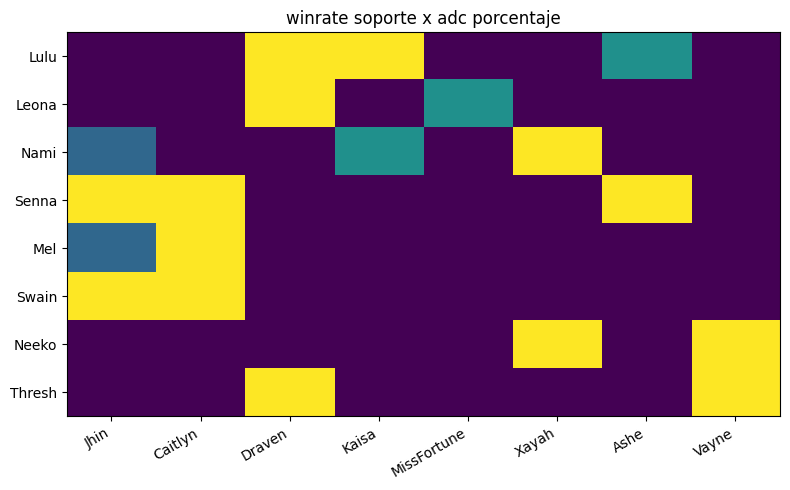

In [22]:
# Juan: heatmap soporte x adc winrate top 8 x top 8

sup_top = df["champion"].value_counts().head(8).index.tolist()

adc_top = df["adc_mate"].value_counts().head(8).index.tolist()

pivot = df[df["champion"].isin(sup_top) & df["adc_mate"].isin(adc_top)].pivot_table(index="champion", columns="adc_mate", values="win", aggfunc="mean")

pivot = (pivot * 100).round(1).fillna(0)

arr = pivot.loc[sup_top, adc_top].values

plt.figure(figsize=(8, 5))

plt.imshow(arr, aspect="auto")

plt.yticks(range(len(sup_top)), sup_top)

plt.xticks(range(len(adc_top)), adc_top, rotation=30, ha="right")

plt.title("winrate soporte x adc porcentaje")

plt.tight_layout()

plt.show()


/tmp/ipython-input-499896652.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wr_by_bin = df.groupby("dur_bin")["win"].mean().reindex(labels).fillna(0) * 100


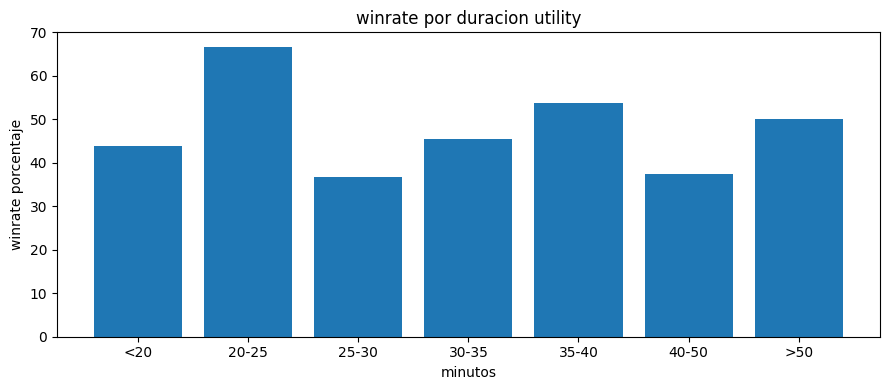

In [23]:
# Juan: wr por duracion de partida

bins = [0, 20, 25, 30, 35, 40, 50, 100]

labels = ["<20","20-25","25-30","30-35","35-40","40-50",">50"]

df["dur_bin"] = pd.cut(df["duration_mins"], bins=bins, labels=labels, include_lowest=True)

wr_by_bin = df.groupby("dur_bin")["win"].mean().reindex(labels).fillna(0) * 100

plt.figure(figsize=(9,4))

plt.bar(wr_by_bin.index.astype(str), wr_by_bin.values)

plt.title("winrate por duracion utility")

plt.xlabel("minutos")

plt.ylabel("winrate porcentaje")

plt.tight_layout()

plt.show()


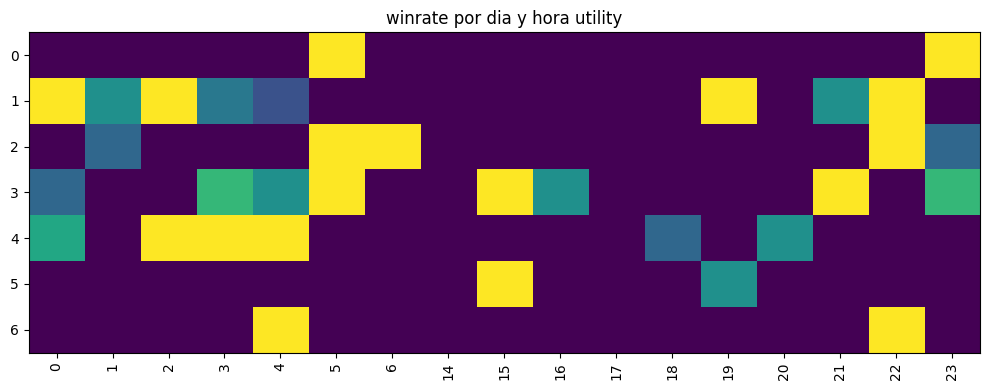

In [24]:
# Juan: mapa de calor hora x dia con winrate

if df["weekday"].notna().any() and df["hour"].notna().any():

    pvt = df.pivot_table(index="weekday", columns="hour", values="win", aggfunc="mean") * 100

    pvt = pvt.fillna(0)

    arr = pvt.values

    plt.figure(figsize=(10, 4))

    plt.imshow(arr, aspect="auto")

    plt.yticks(range(pvt.shape[0]), [str(i) for i in pvt.index.tolist()])

    plt.xticks(range(pvt.shape[1]), [str(int(x)) for x in pvt.columns.tolist()], rotation=90)

    plt.title("winrate por dia y hora utility")

    plt.tight_layout()

    plt.show()

else:

    print("sin datos de hora o dia para mapa de calor")


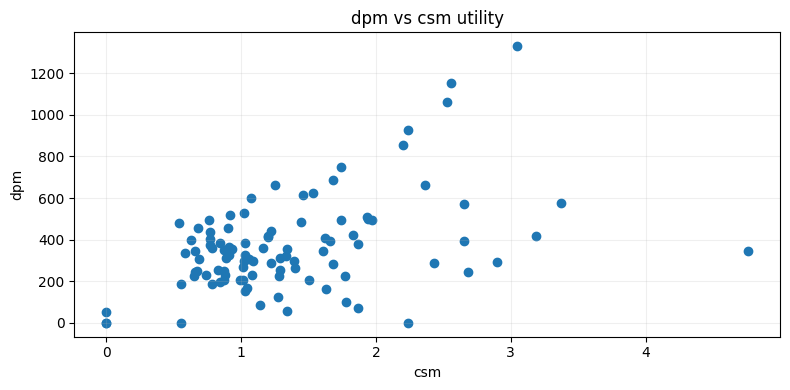

In [25]:
# Juan: scatter dpm vs csm utility

plt.figure(figsize=(8,4))

plt.scatter(df["csm"], df["dpm"])

plt.title("dpm vs csm utility")

plt.xlabel("csm")

plt.ylabel("dpm")

plt.grid(True, alpha=0.2)

plt.tight_layout()

plt.show()


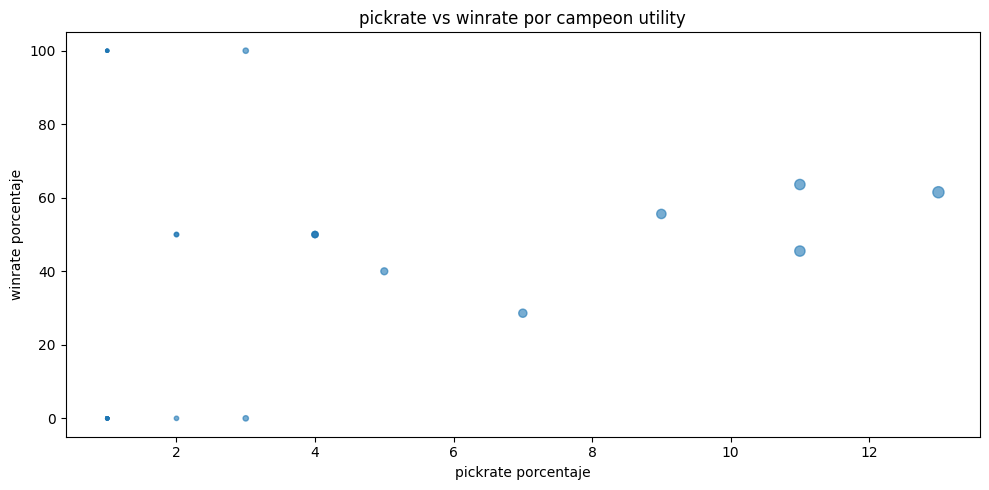

In [26]:
# Juan: burbujas pickrate vs winrate por campeon utility

sub = agg_champ.copy()

sub["pickrate"] = sub["games"] / max(1, df["match_id"].nunique()) * 100

sizes = (sub["pickrate"] * 5).values

plt.figure(figsize=(10,5))

plt.scatter(sub["pickrate"], sub["winrate"], s=sizes, alpha=0.6)

plt.title("pickrate vs winrate por campeon utility")

plt.xlabel("pickrate porcentaje")

plt.ylabel("winrate porcentaje")

plt.tight_layout()

plt.show()


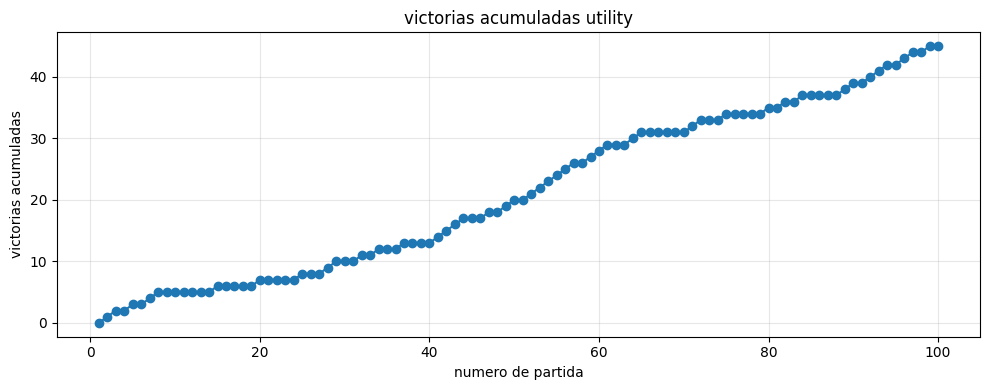

In [27]:
# Juan: curva acumulada de victorias utility

wins_series = df["win"].astype(int).cumsum()

plt.figure(figsize=(10,4))

plt.plot(range(1, len(wins_series)+1), wins_series, marker="o")

plt.title("victorias acumuladas utility")

plt.xlabel("numero de partida")

plt.ylabel("victorias acumuladas")

plt.grid(True, alpha=0.3)

plt.tight_layout()

plt.show()


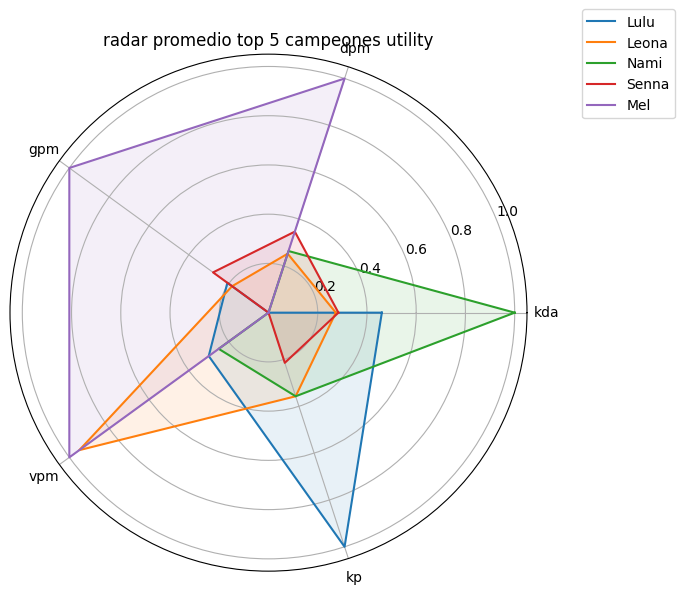

In [28]:
# Juan: radar promedio top 5 campeones normalizado

top5 = df["champion"].value_counts().head(5).index.tolist()

metrics = ["kda","dpm","gpm","vpm","kp"]

stats = agg_champ.set_index("champion").loc[top5, [m + "_avg" if m != "kp" else "kp_avg" for m in metrics]].copy()

stats = stats.fillna(0)

vals = stats.values

mins = vals.min(axis=0)

maxs = vals.max(axis=0)

rng = np.where((maxs - mins) == 0, 1, (maxs - mins))

normed = (vals - mins) / rng

angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()

angles += angles[:1]

plt.figure(figsize=(7,7))

ax = plt.subplot(111, polar=True)

for i, champ in enumerate(top5):

    data = normed[i].tolist()

    data += data[:1]

    ax.plot(angles, data, label=champ)

    ax.fill(angles, data, alpha=0.1)

ax.set_thetagrids(np.degrees(angles[:-1]), metrics)

plt.title("radar promedio top 5 campeones utility")

plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()

plt.show()


In [29]:
# Juan: guardar datasets y resumenes utility v6_3

df.to_csv("lol_utility_100_v6_3.csv", index=False)

agg_champ.to_csv("lol_utility_resumen_campeon_v6_3.csv", index=False)

agg_adc.to_csv("lol_utility_resumen_adc_v6_3.csv", index=False)

agg_patch.to_csv("lol_utility_resumen_patch_v6_3.csv", index=False)

print("archivos guardados v6_3")


archivos guardados v6_3
